In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
np.random.seed(42)

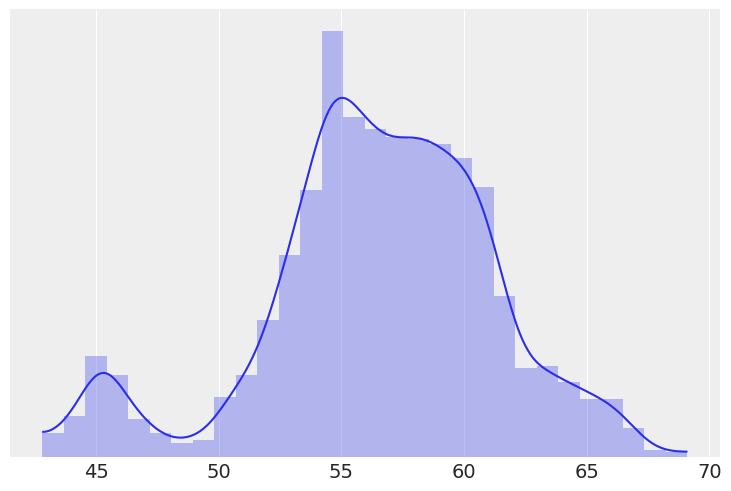

In [4]:
cs = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
az.plot_kde(cs_exp)
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])
plt.savefig('B11197_06_02.png')

In [5]:
#with pm.Model() as model_kg:
#    p = pm.Dirichlet('p', a=np.ones(clusters))
#    z = pm.Categorical('z', p=p, shape=len(cs_exp))
#    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
#    sd = pm.HalfNormal('sd', sd=10)
#
#    y = pm.Normal('y', mu=means[z], sd=sd, observed=cs_exp)
#    idata_kg = pm.sample(return_inferencedata=True)

In [5]:
clusters = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    idata_mg = pm.sample(random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


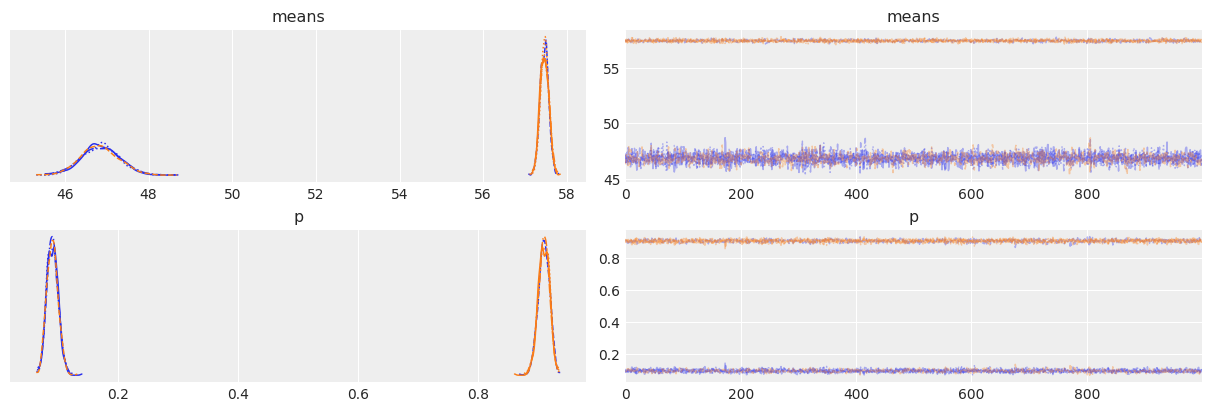

In [6]:
varnames = ['means', 'p']
az.plot_trace(idata_mg, varnames)
plt.savefig('B11197_06_06.png')

In [7]:
az.summary(idata_mg, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],49.505,4.611,46.209,57.654,2.289,1.753,7.0,30.0,1.53
means[1],54.807,4.614,46.472,57.697,2.295,1.757,7.0,30.0,1.53
p[0],0.295,0.355,0.075,0.920,0.177,0.135,7.0,30.0,1.53
p[1],0.705,0.355,0.080,0.925,0.177,0.135,7.0,30.0,1.53


## Non-identifiability of mixture models

In [8]:
clusters = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=np.array([.9, 1]) * cs_exp.mean(),
                      sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    order_means = pm.Potential('order_means',
                               tt.switch(means[1]-means[0] < 0,
                                         -np.inf, 0))
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    idata_mgp = pm.sample(1000, random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [10]:
# instead of a potential we can use an ordered transformation
# transform=pm.distributions.transforms.ordered

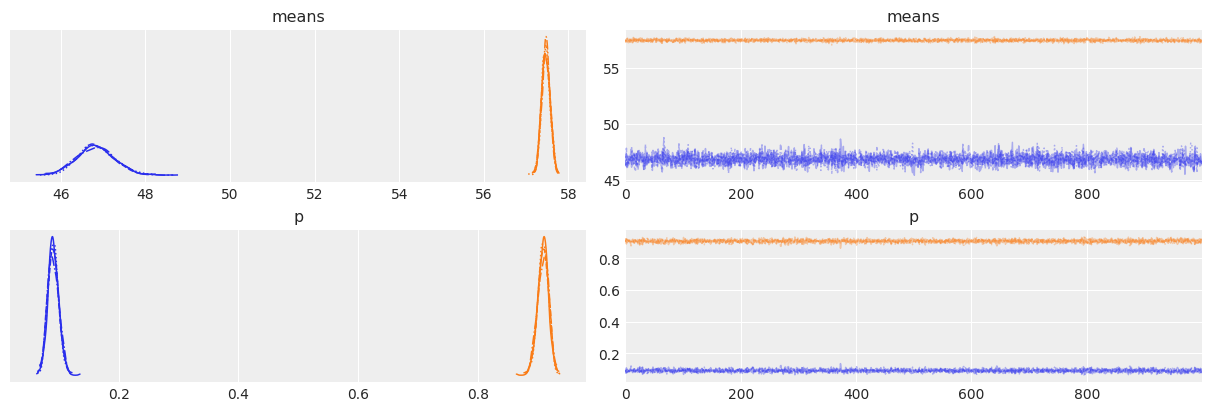

In [9]:
varnames = ['means', 'p']
az.plot_trace(idata_mgp, varnames)
plt.savefig('B11197_06_07.png')

In [10]:
az.summary(idata_mgp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],46.831,0.440,46.050,47.666,0.007,0.005,3966.0,2853.0,1.0
means[1],57.466,0.100,57.278,57.646,0.002,0.001,4285.0,3092.0,1.0
p[0],0.091,0.009,0.073,0.108,0.000,0.000,3819.0,3342.0,1.0
p[1],0.909,0.009,0.892,0.927,0.000,0.000,3819.0,3342.0,1.0
sd,3.652,0.074,3.517,3.793,0.001,0.001,5432.0,3013.0,1.0


## How to choose K

In [11]:
clusters = [3, 4, 5, 6]

models = []
idatas = []
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means',
                          mu=np.linspace(cs_exp.min(), cs_exp.max(), cluster),
                          sd=10, shape=cluster,
                          transform=pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
        idata = pm.sample(1000, tune=2000, target_accept=0.9, random_seed=123, return_inferencedata=True)
        idatas.append(idata)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 37 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 40 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 94 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 144 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6307981296827975, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


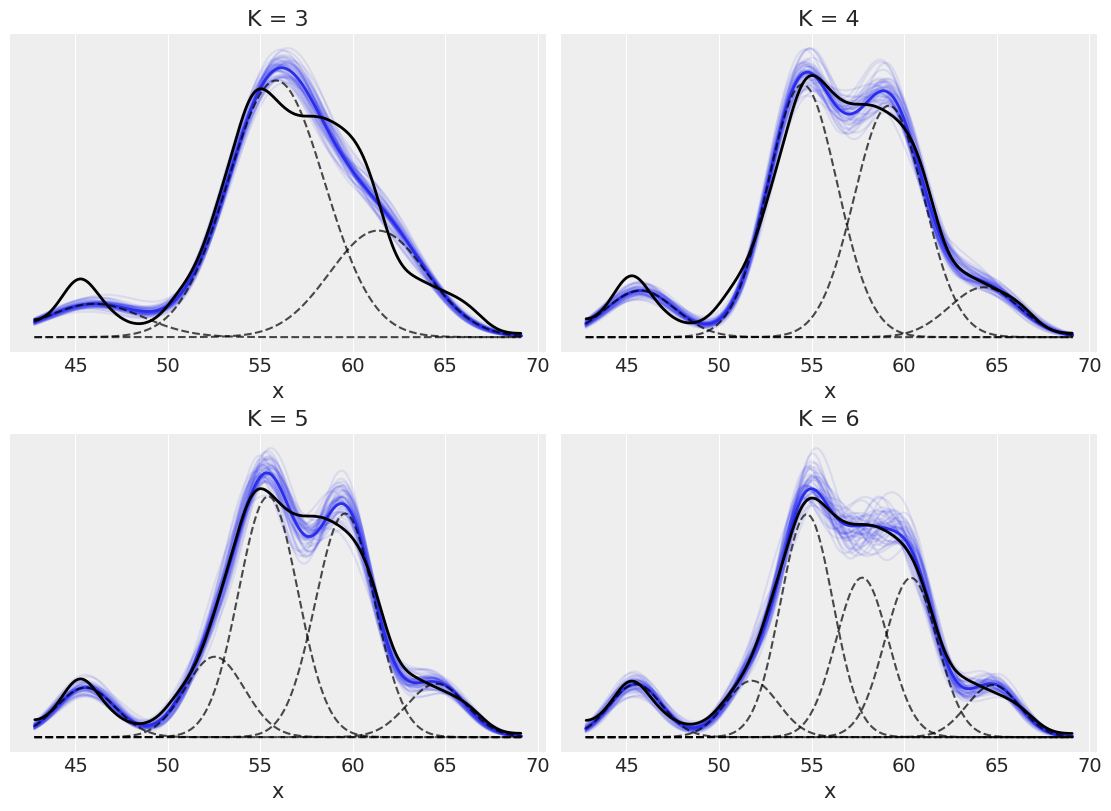

In [12]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
 
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * clusters[idx]).T
 
    for i in range(50):
        i_ = np.random.randint(0, posterior_x.samples.size)
        means_y = posterior_x['means'][:,i_]
        p_y = posterior_x['p'][:,i_]
        sd = posterior_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'C0', alpha=0.1)
 
    means_y = posterior_x['means'].mean("samples")
    p_y = posterior_x['p'].mean("samples")
    sd = posterior_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y.values, 'k--', alpha=0.7)
         
    az.plot_kde(cs_exp, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')
plt.savefig('B11197_06_08.png')

In [13]:
ppc_mm = [pm.sample_posterior_predictive(idatas[i], 1000, models[i])
          for i in range(4)]

/Users/christopher.brossman/anaconda3/envs/newbase/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


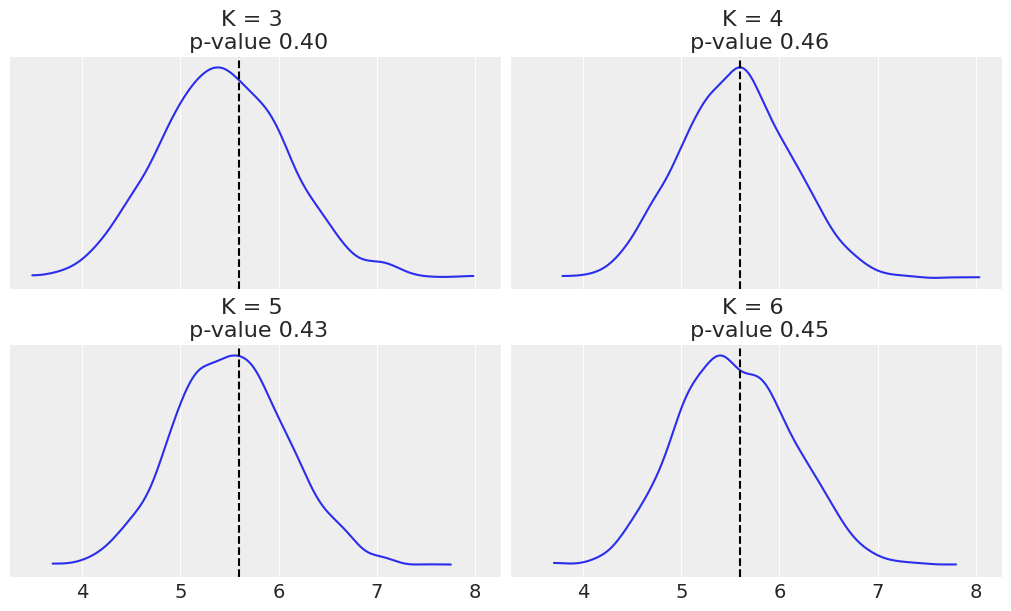

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])
plt.savefig('B11197_06_09.png')

In [15]:
comp = az.compare(dict(zip([str(c) for c in clusters], idatas)),
                  method='BB-pseudo-BMA', ic="waic", scale="deviance")
comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
6,0,10249.949209,12.559018,0.000000,9.136976e-01,63.240321,0.000000,False,deviance
5,1,10258.251067,9.760702,8.301858,8.446830e-02,61.406031,4.746179,False,deviance
4,2,10279.362718,7.692453,29.413508,1.834142e-03,60.668708,10.007968,False,deviance
3,3,10356.771124,5.851889,106.821915,6.170348e-13,60.633395,18.674607,False,deviance


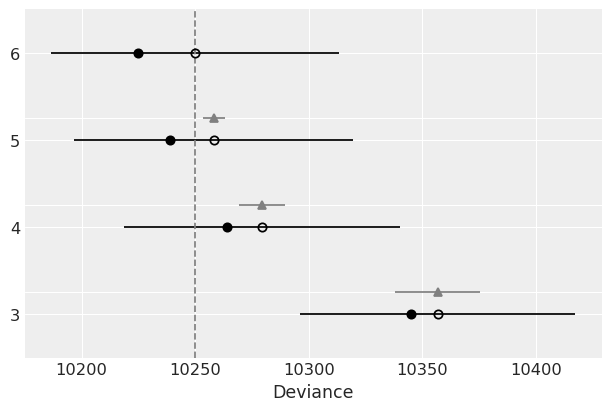

In [16]:
az.plot_compare(comp)
plt.savefig('B11197_06_10.png')

## Non-finite mixture model

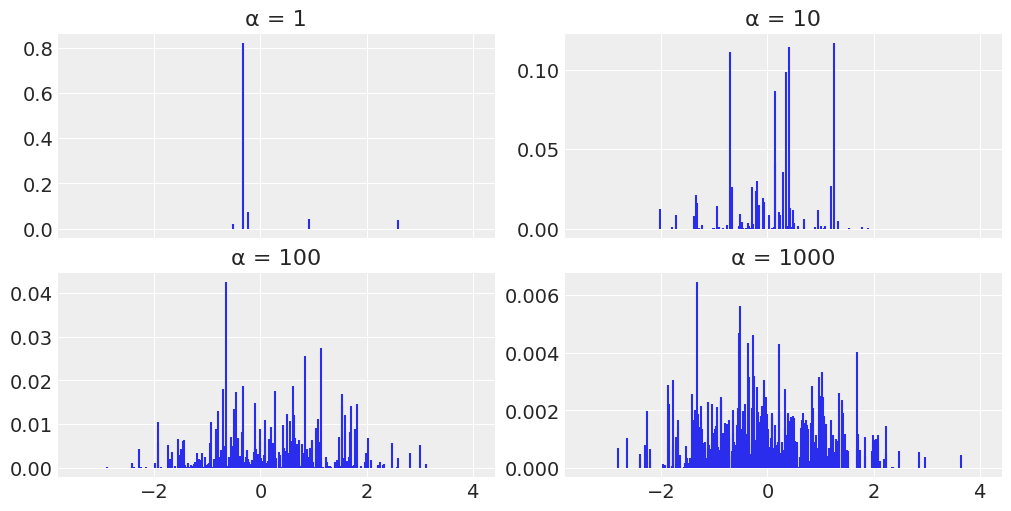

In [17]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    
    Parameters
    ----------
    α : float
        concentration parameter
    H : scipy distribution
        Base distribution
    K : int
        number of components
    
    Returns
    -------
    locs : array
        locations
    w : array
        probabilities
    """
    βs = stats.beta.rvs(1, α, size=K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    locs = H.rvs(size=K)
    return locs, w

# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]

# plot
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0')
    ax[idx].set_title('α = {}'.format(α))

plt.savefig('B11197_06_11.png')

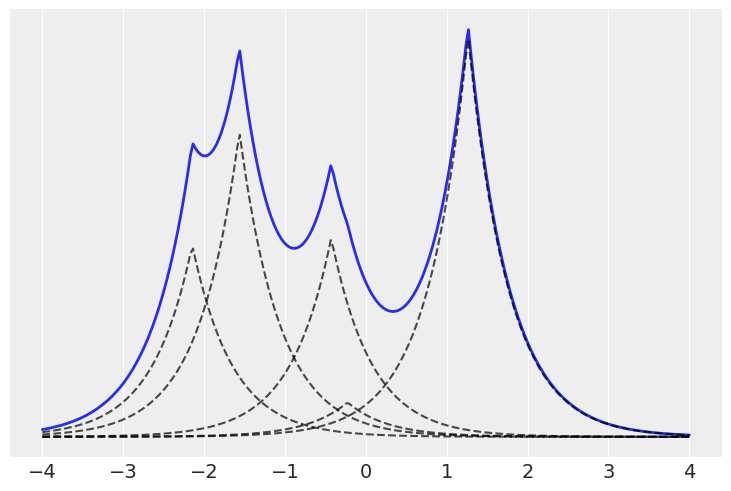

In [18]:
α = 10
H = stats.norm
K = 5

x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)

dist = stats.laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])
plt.savefig('B11197_06_12.png')

In [19]:
K = 20

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [20]:
with pm.Model() as model:
    α = pm.Gamma('α', 1, 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means',
                      mu=np.linspace(cs_exp.min(), cs_exp.max(), K),
                      sd=10, shape=K)
    
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp.values)
    idata = pm.sample(1000, tune=2000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, β, α]


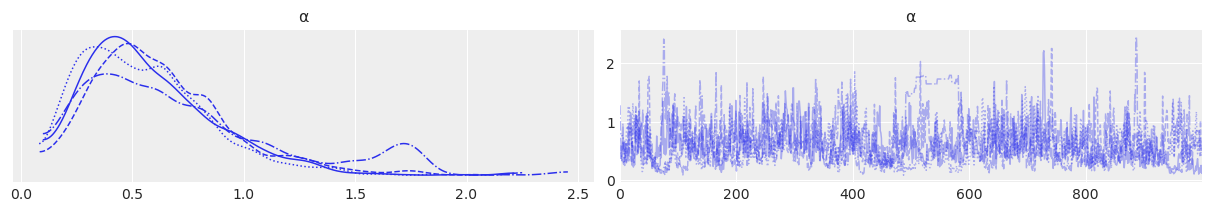

In [ ]:
az.plot_trace(idata, var_names=['α'], divergences=False);
plt.savefig('B11197_06_13.png')

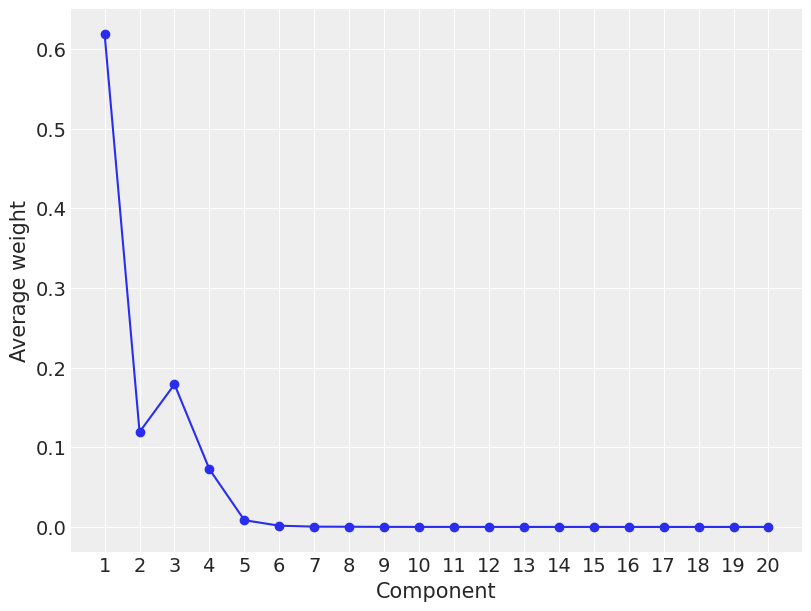

In [ ]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, idata.posterior['w'].mean(("chain", "draw")), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')
plt.savefig('B11197_06_14.png')

In [ ]:
x_plot = np.linspace(cs.exp.min()-1, cs.exp.max()+1, 200)

posterior = idata.posterior.stack(samples=("chain", "draw"))

post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                   posterior['means'].values[:, np.newaxis, :],
                                   posterior['sd'].values[:, np.newaxis, :])
post_pdfs = (posterior['w'].values[:, np.newaxis, :] * post_pdf_contribs).sum(axis=0)

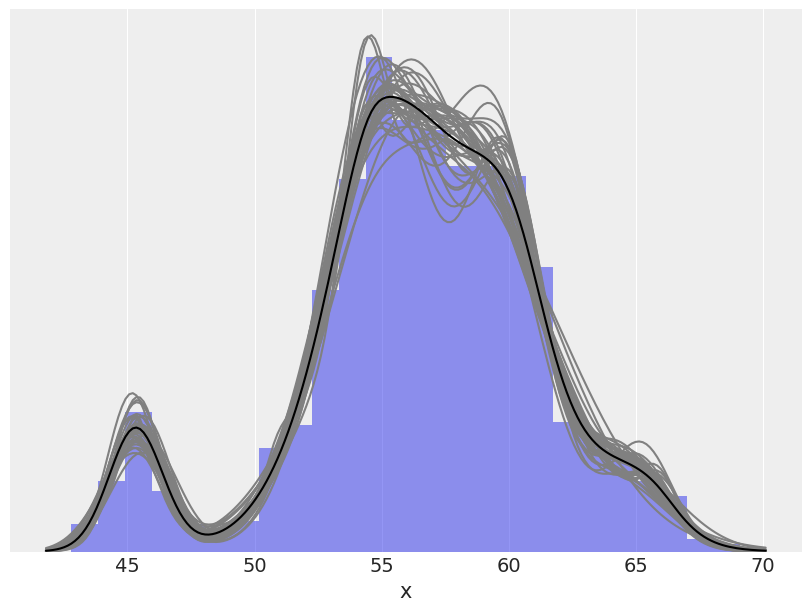

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(cs_exp.values, bins=25, density=True, alpha=0.5)
plt.plot(x_plot, post_pdfs[:,::100], c='0.5')
plt.plot(x_plot, post_pdfs.mean(axis=1), c='k')

plt.xlabel('x')
plt.yticks([])
plt.savefig('B11197_06_15.png')

In [27]:
## Exercises
#clusters = 3
#n_cluster = [200, 150, 170]
#n_total = sum(n_cluster)
#means = [5, 0, -3]
#std_devs = [2, 2, 2]
#mix = np.random.normal(np.repeat(means, n_cluster),
#np.repeat(std_devs, n_cluster))
#az.plot_kde(np.array(mix));